# Classification KNN of Thyroid Dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np


from sklearn.preprocessing import label_binarize
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#helper functions

In [2]:
def parse_row(row):
    row = row.split(".")[0]
    return row

def to_hyperthyroid(row):
    if row != "negative":
        row = "hyperthyroid"
    return row

def to_hypothyroid(row):
    if row != "negative":
        row = "hypothyroid"
    return row

def convert_category(dataframe, column):
    
    if column == 'Sex':
        conditionF = dataframe[column] == 'F' # For sex column
        conditionT = dataframe[column] == 'M' # For sex column
    else:
        conditionF = dataframe[column] == 'f'
        conditionT = dataframe[column] == 't'
    
    dataframe.loc[conditionF, column] = 0
    dataframe.loc[conditionT, column] = 1

# Data Retrival

In [3]:
columns = ["Age", "Sex", "On Thyroxine", "Query on Thyroxine", 
           "On Antithyroid Medication", "Sick", "Pregnant", 
           "Thyroid Surgery", "I131 Treatment", "Query Hypothyroid", 
           "Query Hyperthyroid", "Lithium", "Goitre", "Tumor", 
           "Hypopituitary", "Psych", "TSH Measured", "TSH", "T3 Measured", 
           "T3", "TT4 Measured", "TT4", "T4U Measured", "T4U", 
           "FTI Measured", "FTI", "TBG Measured", "TBG", "Referral Source", "Category"]

In [4]:
hyper_data = pd.read_csv("hypothyroid.csv", names=columns)
hypo_data = pd.read_csv("hypothyroid.csv", names=columns)
sick_data = pd.read_csv("hypothyroid.csv", names=columns)

In [5]:
hyper_data['Category'] = hyper_data['Category'].apply(parse_row).apply(to_hyperthyroid)

hypo_data['Category'] = hypo_data['Category'].apply(parse_row).apply(to_hypothyroid)

sick_data['Category'] = sick_data['Category'].apply(parse_row)

In [6]:
# Combined Thyroid Data

thyroid_frames = [hyper_data, hypo_data, sick_data]
thyroid_data = pd.concat(thyroid_frames).drop_duplicates().drop(['Referral Source', 'TBG', 'TBG Measured'], axis=1)

In [7]:
classes = thyroid_data['Category'].unique()
classes

array(['hyperthyroid', 'hypothyroid', 'binaryClass', 'P', 'N'],
      dtype=object)

In [8]:
print("Number of samples:", len(thyroid_data))

Number of samples: 11136


In [18]:
thyroid_data.head()

,Age,Sex,On Thyroxine,Query on Thyroxine,On Antithyroid Medication,Sick,Pregnant,Thyroid Surgery,I131 Treatment,Query Hypothyroid,...,TSH,T3 Measured,T3,TT4 Measured,TT4,T4U Measured,T4U,FTI Measured,FTI,Category
0,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,hyperthyroid
1,41,F,f,f,f,f,f,f,f,f,...,1.3,t,2.5,t,125,t,1.14,t,109,hyperthyroid
2,23,F,f,f,f,f,f,f,f,f,...,4.1,t,2,t,102,f,?,f,?,hyperthyroid
3,46,M,f,f,f,f,f,f,f,f,...,0.98,f,?,t,109,t,0.91,t,120,hyperthyroid
4,70,F,t,f,f,f,f,f,f,f,...,0.16,t,1.9,t,175,f,?,f,?,hyperthyroid


# Data Cleaning

In [19]:
# A quick fix needed
#thyroid_data.loc[thyroid_data['Age'] == '455', 'Age'] = '45'

In [9]:
# Binarize Category Columns
binary_cols = ['On Thyroxine', 'Query on Thyroxine', 'Sex',
               'On Antithyroid Medication', 'Sick', 'Pregnant', 
               'Thyroid Surgery', 'I131 Treatment', 'Query Hypothyroid', 
               'Query Hyperthyroid', 'Lithium', 'Goitre', 'Tumor', 
               'Hypopituitary', 'Psych', 'TSH Measured', 'T3 Measured', 
               'TT4 Measured', 'T4U Measured', 'FTI Measured']

for col in binary_cols: convert_category(thyroid_data, col)

In [10]:
thyroid_data=thyroid_data.drop(0)

In [11]:
# Convert '?' to np.nan and convert numeric data to numeric dtype

for col in thyroid_data.columns: 
    if col != 'Category':
        thyroid_data.loc[thyroid_data[col] == '?', col] = np.nan
        thyroid_data['Age'] = pd.to_numeric(thyroid_data['Age'],errors= 'coerce')

In [12]:
curr_columns = thyroid_data.columns.difference(['Category'])

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputed_data = imputer.fit_transform(thyroid_data.drop('Category', axis=1))
imputed_data = pd.DataFrame(imputed_data, columns=curr_columns)

thyroid_data = pd.concat([
                    imputed_data.reset_index(), 
                    thyroid_data['Category'].reset_index()], 
                    axis=1).drop('index', axis=1)

In [13]:
thyroid_data['Category'].unique()

array(['hyperthyroid', 'hypothyroid', 'P', 'N'], dtype=object)

In [14]:
for col in thyroid_data.columns: 
    print("Unique of Colum-",col ,"\nUnique values \n",np.sort(thyroid_data[col].unique()))

Unique of Colum- Age 
Unique values 
 [  1.   2.   4.   5.   6.   7.   8.  10.  11.  12.  13.  14.  15.  16.
  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.
  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.
  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.
  87.  88.  89.  90.  91.  92.  93.  94. 455.]
Unique of Colum- FTI 
Unique values 
 [0. 1.]
Unique of Colum- FTI Measured 
Unique values 
 [0. 1.]
Unique of Colum- Goitre 
Unique values 
 [0. 1.]
Unique of Colum- Hypopituitary 
Unique values 
 [0. 1.]
Unique of Colum- I131 Treatment 
Unique values 
 [0. 1.]
Unique of Colum- Lithium 
Unique values 
 [0. 1.]
Unique of Colum- On Antithyroid Medication 
Unique values 
 [0. 1.]
Unique of Colum- On Thyroxine 
Unique values 
 [0. 1.]
Unique of Colum- Pregnant 
Unique values 
 [0. 1.]
Un

# Split Data

In [15]:
X = thyroid_data.drop('Category', axis=1)
y = thyroid_data['Category']

col_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

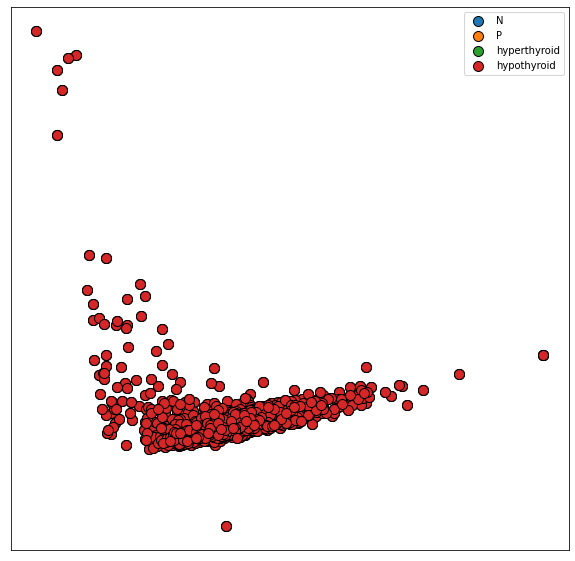

In [16]:
def plot_pca_data(X, y):    
    
    LE = LabelEncoder()
    y_encoded = LE.fit_transform(y)
    
    pca = PCA(n_components=2)
    pca.fit(X)
    pca_X = pca.transform(X)

    x_axis = pca_X[:,0]
    y_axis = pca_X[:,1]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    for label in np.unique(y):
        ax.scatter(pca_X[y==label, 0],
                   pca_X[y==label, 1], 
                   label=label,
                   s=100,
                   edgecolor='k')
        

    ax.legend()
    plt.xticks([])
    plt.yticks([])

plot_pca_data(X, y)

# Parameter of KNN Selection

In [18]:
n_neighbors = np.array(range(1,160))
param_grid = dict(n_neighbors=n_neighbors)   #param_grid needs to be dictionary

In [22]:
model = KNeighborsClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(X, y)
print(grid.best_score_) 
print(grid.best_params_)

0.3323451345106673
{'n_neighbors': 159}


# Visualizing CV Results

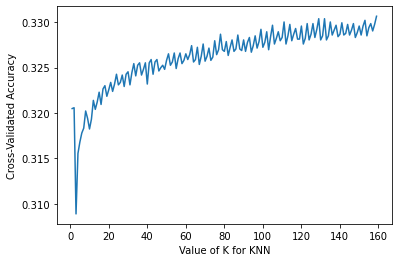

In [24]:
import matplotlib.pyplot as plt 
%matplotlib inline
# choose k between 1 to 41
k_range = range(1, 160)
k_scores = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10)
    k_scores.append(scores.mean())
# plot to see clearly
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

# Evaluate Model

In [25]:
#Error Rate

#import required packages
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
rmse_val = [] #to store rmse values for different k
for K in range(160):
    K = K+1
    model = KNeighborsClassifier(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(x_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

NameError: name 'x_train' is not defined

# Classify on Test Set

In [33]:
#predicting on the test set and creating submission file

#data_pred
model = KNeighborsClassifier(n_neighbors = 159)
model.fit(X_train, y_train)  #fit the 


accuracy=model.score(X_test, y_test)*100

print("\nAccuracy of Model is :",accuracy)


y_true, y_pred = y_test, model.predict(X_test)




Accuracy of Model is : 28.089080459770116


'\n##\ny_true, y_pred = y_test, svm_clf.predict(X_test)\n\nprint("Accuracy:",accuracy_score(y_test, y_pred))\nprint("*"*50)\nprint()\nprint("\t\t\tClassification Report")\nprint()\nprint(classification_report(y_true, y_pred))\n'

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=classes)
print(cm)

[[320 399   0 209   0]
 [399 300   0 229   0]
 [  0   0   0   0   0]
 [357 336   0 162   0]
 [ 31  39   0   3   0]]
